# Determinant QMC data visualization

## Are you testing or making plots?

In [1]:
SAVEPLOTS = True

## Load simulation data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import warnings
cwd = os.getcwd()
import seaborn as sns
sns.set()
sns.set_palette("Blues_r")
sns.set_style("white")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
from pylab import *

NSITES = 16
dt = 0.0625
beta = 4.
L = 64
t = 1.
U = 4.
mu = 0.
totalMCSweeps = 2048
freq = 4
intsize = 16
geom = 3
ny = 0

mainDir = ('../data/' + str(NSITES) + \
             'sites_L=' + str(L) + \
             '_beta=' + str(beta) + \
             '_dt_' + str(dt) + '_t_' + \
             str(t) + '_U_'+ str(U) + '_mu_' + str(mu))

simDir = (mainDir + '/data-to-reproduce/' + \
              'totalMCSweeps_' + str(totalMCSweeps) + \
              '_freq_' + str(freq) + '_intsize_' + str(intsize) + \
              '_geom_' + str(geom) + '_ny_' + str(ny) )

plotDir = (mainDir + '/plots/' + \
              'totalMCSweeps_' + str(totalMCSweeps) + \
              '_freq_' + str(freq) + '_intsize_' + str(intsize) + \
              '_geom_' + str(geom) + '_ny_' + str(ny) )

# Load weights to plot

weights = np.loadtxt(simDir + '/Log-weights.csv')

WL = weights.size

latSweeps = np.arange(WL) + 1

# Metropolis Sampling convergence

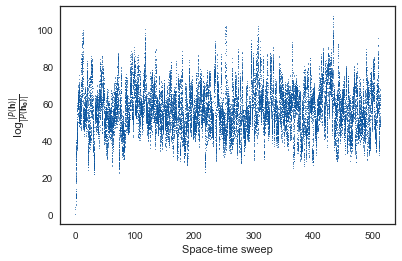

In [3]:
plt.scatter(latSweeps / L, weights, s = 0.3) #show time in space-time sweeps
plt.xlabel(r"Space-time sweep")
plt.ylabel(r'$\log \frac{| P(\mathbf{h}) | }{ | P(\mathbf{h_0}) | } $')
if SAVEPLOTS == True:
    plt.savefig(plotDir + '/Log-weights.png', dpi = 600)

# Magnetic structure factor $S(\mathbf q) = \frac{1}{N} \sum_{i, j} e^{i \mathbf q \cdot  (\mathbf i - \mathbf j)} \left\langle \mathbf S_{\mathbf i} \cdot \mathbf S_{\mathbf j} \right\rangle $

## Auto-correlation time in the measurement of the correlation function

In [20]:
magCorr = np.loadtxt(simDir + '/EqTimeSzCorrelations.csv')

Nx = int(np.sqrt(NSITES))

Ny = int(NSITES / Nx)

gridX = np.arange(Nx)

gridY = np.arange(Ny)

flatCorrs = np.zeros((Nx, Ny))

for x1 in range(Nx):
    for y1 in range(Ny):
        for x2 in range(Nx):
            for y2 in range(Ny):
                flatCorrs[x2-x1, y2-y1] = magCorr[Nx * y1 + x1, Nx*y2 + x2]

print("Correlations by distance:\n", flatCorrs)

Correlations by distance:
 [[ 0.75177129 -0.20926     0.09211742 -0.1877524 ]
 [-0.2120198   0.11246415 -0.12306691  0.07818774]
 [ 0.08842062 -0.09558146  0.13240261 -0.08800512]
 [-0.17237014  0.09317448 -0.09813616  0.10402557]]


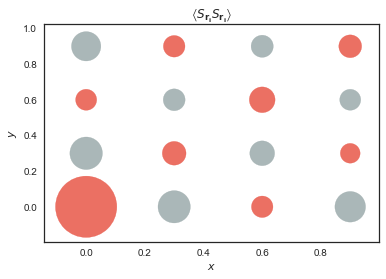

In [47]:
plt.figure(1, figsize = (5,5))
clr = np.chararray((Nx * Ny), itemsize = 10)

a1 = np.arange(Nx)
a2 = np.arange(Ny)

vs = np.zeros((Nx * Ny , 2))
v1 = 0.3 *np.array([1, 0])
v2 = 0.3 *np.array([0, 1])
#v2 = np.array([1 / 2, np.sqrt(3) / 2])
                
for i in range(Nx):
    for j in range(Ny):
        vs[Nx * j + i, :] =\
                a1[i] * v1 + a2[j] * v2 
        if flatCorrs[i, j] > 0:
            clr[Nx * j + i] = "#e74c3c"
        else:
            clr[Nx * j + i] = "#95a5a6"

dotscale = 5000

fig, ax = plt.subplots()

ax.scatter(vs[:, 0], vs[:, 1], s = dotscale * abs(flatCorrs),\
           c = clr.decode('UTF-8'), alpha = 0.8, edgecolors = None)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.savefig(plotDir + '/CorrelationsDots.png', dpi = 600)

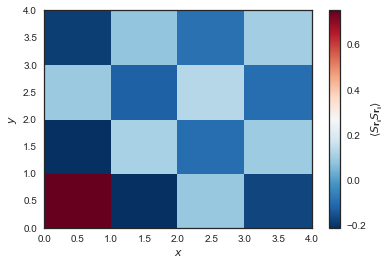

In [48]:
gridX = np.arange(Nx+1)
gridY = np.arange(Ny+1)

fig, ax = plt.subplots()

p = ax.pcolor(gridX, gridY, flatCorrs.T, cmap=cm.RdBu_r)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
cb = fig.colorbar(p)
cb.set_label(r'$\left\langle S_{\bf{r}_i} S_{\bf{r}_i} \right\rangle$')
plt.savefig(plotDir + '/CorrelationsSquares.png', dpi = 600)

## Fourier transform to obtain the structure factor    

In [49]:
n_qs = NSITES
qMax = 2*np.pi
qsX = np.arange(0, qMax + qMax/n_qs, qMax/n_qs)
qsY = np.arange(0, qMax + qMax/n_qs, qMax/n_qs)
S = np.zeros((n_qs+1, n_qs+1))
dist = 0

for idxX, qx in enumerate(qsX):
    for idxY, qy in enumerate(qsY):
        for x1 in range(Nx):
            for y1 in range(Nx):
                for x2 in range(Nx):
                    for y2 in range(Nx):
                        S[idxX, idxY] += np.cos((x1 - x2) * qx + (y1-y2) *qy ) * magCorr[Nx * y1 + x1, Nx*y2 + x2]

S /=  (NSITES) # factor of 16 comes from 1/2 spins and overcounting


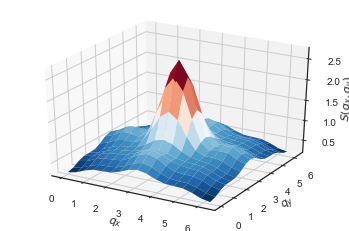

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(qsX, qsY)
ax.plot_surface(X, Y, S,
                cmap=cm.get_cmap('RdBu_r'), edgecolor='none')
ax.set_xlabel(r'$q_x$')
ax.set_ylabel(r'$q_y$')
ax.set_zlabel(r'$S(q_x, q_y)$')
plt.savefig(plotDir + '/S(q).png', dpi = 600)

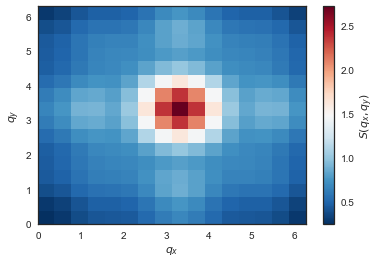

In [51]:
fig, ax = plt.subplots()

p = ax.pcolor(qsX, qsY, S.T, cmap=cm.RdBu_r)
plt.xlabel(r'$q_x$')
plt.ylabel(r'$q_y$')
cb = fig.colorbar(p)
cb.set_label(r'$S(q_x, q_y)$')
plt.savefig(plotDir + '/S(q)pcolor.png', dpi = 600)

### Antiferromagnetism

It has a maximum at $\bf{q} = \bf{\pi}$ signaling quasi-AF order

In [64]:
maxInds = np.unravel_index(np.argmax(S), (n_qs+1, n_qs+1))

print("Maximum of S(q): ")
print('qx', qsX[maxInds[0]])
print('qy', qsY[maxInds[0]])

Maximum of S(q): 
qx 3.14159265359
qy 3.14159265359


## ## A comparison that could be useful

By the definition of the ZZ magnetic susceptibility

$\chi(\mathbf q) = \frac{1}{N} \sum_{i, j} e^{i \mathbf q \cdot  (\mathbf i - \mathbf j)} \int_0^\beta \left\langle \mathbf S_{\mathbf i}(\tau) \cdot \mathbf S_{\mathbf j}(0) \right\rangle d\tau $

we obtain an important identity

$\chi ( 0 ) = \beta S ( 0 ) ,$

which we used to check whether our results are consistent.

Unequal-time measurements are more prone to fluctuations and thus there are minor variations due to higher variance of the corresponding estimators.

In [63]:
print("beta S (0): ", S[0, 0] * beta)

beta S (0):  0.971153254665


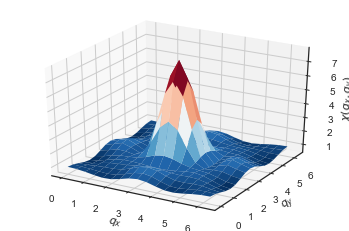

In [53]:
UneqMagCorr = np.loadtxt(simDir + '/UneqTimeSzCorrelations.csv')

# Compute structure factor    
    
n_qs = NSITES
qMax = 2*np.pi
threshold = 0
qsX = np.arange(threshold * qMax/n_qs, qMax - (threshold - 1) * qMax/n_qs , qMax/n_qs)
qsY = np.arange(threshold * qMax/n_qs, qMax - (threshold - 1) * qMax/n_qs , qMax/n_qs)
MagSus = np.zeros((n_qs - 2 * threshold + 1, n_qs - 2 * threshold + 1))

Nx = int(np.sqrt(NSITES))

for idxX, qx in enumerate(qsX):
    for idxY, qy in enumerate(qsY):
        for x1 in range(Nx):
            for y1 in range(Nx):
                for x2 in range(Nx):
                    for y2 in range(Nx):
                        MagSus[idxX, idxY] += np.cos((x1 - x2) * qx + (y1-y2) *qy ) * UneqMagCorr[Nx * y1 + x1, Nx*y2 + x2]

MagSus /= (NSITES )

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.xlabel(r'q')
plt.ylabel(r'$\chi(q)$')

X, Y = np.meshgrid(qsX, qsY)
ax.plot_surface(X, Y, MagSus,
                cmap=cm.get_cmap('RdBu_r'), edgecolor='none')
ax.set_xlabel(r'$q_x$')
ax.set_ylabel(r'$q_y$')
ax.set_zlabel(r'$\chi(q_x, q_y)$')

if SAVEPLOTS == True:
    plt.savefig(plotDir + '/chi(q).png', dpi = 600)

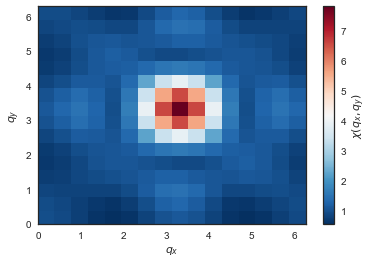

In [54]:
fig, ax = plt.subplots()

p = ax.pcolor(qsX, qsY, MagSus.T, cmap=cm.RdBu_r)
plt.xlabel(r'$q_x$')
plt.ylabel(r'$q_y$')
cb = fig.colorbar(p)
cb.set_label(r'$\chi (q_x, q_y)$')
plt.savefig(plotDir + '/chi(q)pcolor.png', dpi = 600)

### Antiferromagnetism

Again, it has a maximum at $\bf{q} = \bf{\pi}$ signaling quasi-AF order

In [65]:
maxInds = np.unravel_index(np.argmax(MagSus), (n_qs+1, n_qs+1))

print("Maximum of Chi (q)")
print('qx', qsX[maxInds[0]])
print('qy', qsY[maxInds[0]])

Maximum of Chi (q)
qx 3.14159265359
qy 3.14159265359


## $\chi (q = 0 )$ and $\chi (q = \pi )$

In [71]:
print("Chi (q = 0): ", MagSus[0, 0])
print("Chi (q = pi): ", MagSus[maxInds[0], maxInds[0]])

Chi (q = 0):  0.949330654494
Chi (q = pi):  7.82491993346
